# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
from src.sim.scenario import Scenario
from src.metrics import MetricsProcessor
from src.plotting.sim import plot_prices
%load_ext autoreload
%autoreload 2

[DEBUG][01:39:25][root]-786986: Using 626400 1Inch quotes.
[INFO][01:39:25][root]-786986: Fetching sim_market from subgraph.
[INFO][01:39:28][root]-786986: Found 20 valid cycles of length 3.


Running 168 steps with frequency 1h.


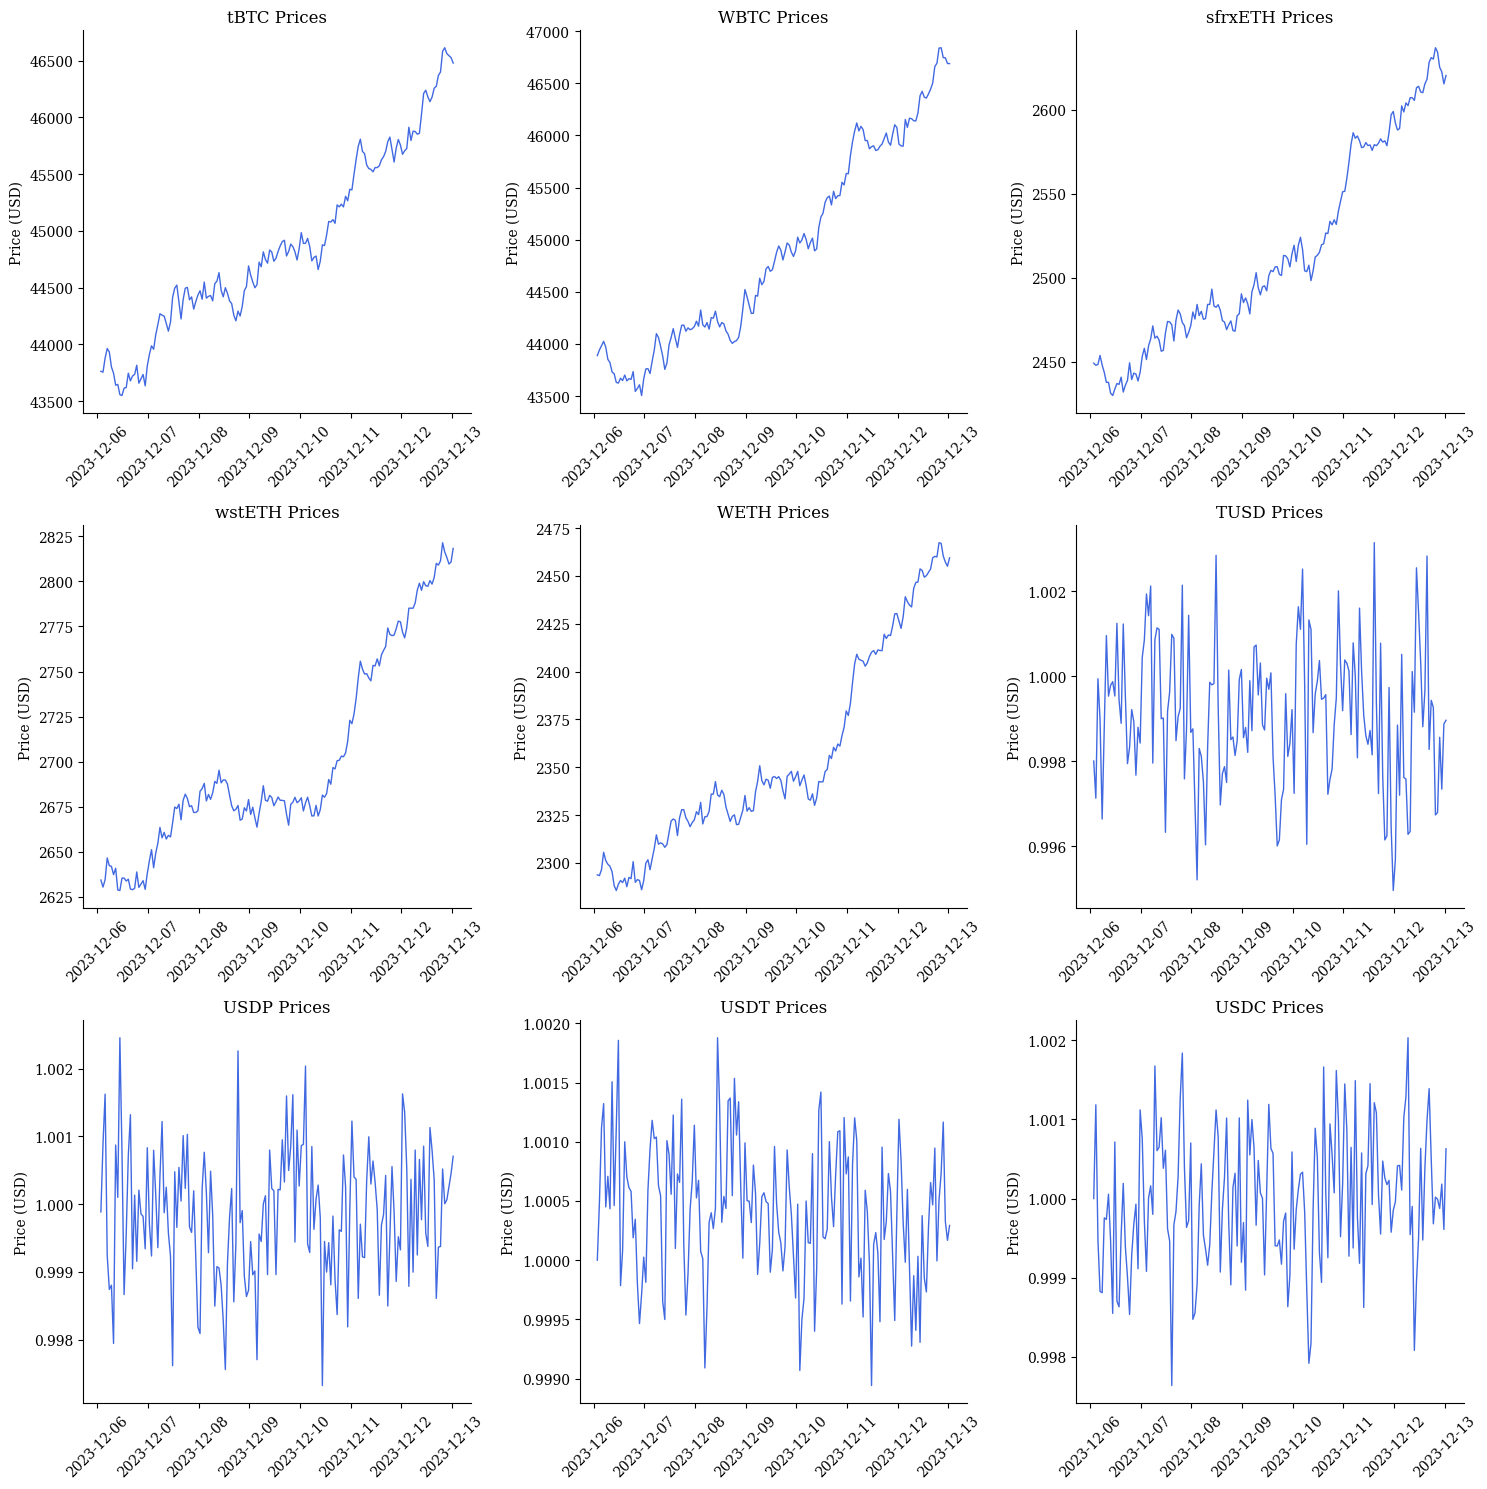

In [2]:
# Generate markets and prices
scenario = Scenario("baseline")
scenario.prepare_for_run()
_ = plot_prices(scenario.pricepaths.prices)
print(f"Running {scenario.num_steps} steps with frequency {scenario.pricepaths.config['freq']}.")

In [3]:
metricsprocessor = MetricsProcessor(scenario)
metricsprocessor.initial_state

{'timestamp': Timestamp('2023-12-06 01:39:16'),
 'arbitrageur_profit': 0,
 'arbitrageur_count': 0,
 'keeper_profit': 0.0,
 'keeper_count': 0,
 'liquidator_profit': 0.0,
 'liquidator_count': 0,
 'llamma_WETH_price': 2268648041010146931618,
 'llamma_WETH_oracle_price': 2292838064607570165760,
 'llamma_WETH_fees_x': 0,
 'llamma_WETH_fees_y': 0,
 'llamma_WETH_bal_x': 0,
 'llamma_WETH_bal_y': 13657040725117335080960,
 'controller_WETH_system_health': 3.476851678613686e+17,
 'controller_WETH_bad_debt': 7426865776185487294464000,
 'controller_WETH_num_loans': 245,
 'controller_WETH_debt': 22098749878229634001903803,
 'stableswap_crvUSD_TUSD_price': 997178462699128223,
 'stableswap_crvUSD_TUSD_ma_price': 997178462699128223,
 'stableswap_crvUSD_TUSD_lp_supply': 4602598847318464060909400,
 'stableswap_crvUSD_TUSD_virtual_price': 1000000000000000000,
 'stableswap_crvUSD_TUSD_TUSD_bal': 1264873466526145414371197,
 'stableswap_crvUSD_TUSD_crvUSD_bal': 3338894426962110535006828,
 'stableswap_crvUSD_

In [4]:
for sample in scenario.pricepaths:
    scenario.prepare_for_trades(sample)
    scenario.perform_actions(sample)
    metricsprocessor.update()

[INFO][01:39:38][root]-786986: There are 47 users to liquidate.
[INFO][01:39:38][root]-786986: Missed liquidation for user 0xf165d7273288ace1e7a317d6d23956e46fe229c5. Health: -705461551450848000.000000. Expected profit: -17244.697413.
[INFO][01:39:38][root]-786986: Missed liquidation for user 0xec718904654b29f1f571290259c324fd2e3aa63e. Health: -879161143277353472.000000. Expected profit: -49483.028019.
[INFO][01:39:38][root]-786986: Missed liquidation for user 0xec263efe3df2b0a5148df59b2551cf46ce8c763e. Health: -391955310352311360.000000. Expected profit: -37835.339288.
[INFO][01:39:38][root]-786986: Missed liquidation for user 0xebdeff4d7053bf84262d2f9fc261a900c4323d83. Health: -618983983460004352.000000. Expected profit: -8442.311299.
[INFO][01:39:38][root]-786986: Missed liquidation for user 0xea3f9b017c6b811b0a8ca642346bd805d936fce4. Health: -268466161303036064.000000. Expected profit: -2794.878848.
[INFO][01:39:38][root]-786986: Missed liquidation for user 0xdf88f68c58edf72a737e1e

In [5]:
df = metricsprocessor.df
df.to_csv("../data/results.csv")
df.head()

,timestamp,arbitrageur_profit,arbitrageur_count,keeper_profit,keeper_count,liquidator_profit,liquidator_count,llamma_WETH_price,llamma_WETH_oracle_price,llamma_WETH_fees_x,...,pk_Curve.fi Factory Plain Pool: crvUSD/TUSD_debt,pk_Curve.fi Factory Plain Pool: crvUSD/TUSD_profit,pk_Curve.fi Factory Plain Pool: crvUSD/USDP_debt,pk_Curve.fi Factory Plain Pool: crvUSD/USDP_profit,pk_Curve.fi Factory Plain Pool: crvUSD/USDC_debt,pk_Curve.fi Factory Plain Pool: crvUSD/USDC_profit,pk_Curve.fi Factory Plain Pool: crvUSD/USDT_debt,pk_Curve.fi Factory Plain Pool: crvUSD/USDT_profit,aggregator_price,stablecoin_total_supply
0,2023-12-06 01:39:16,882.791983,1,0.0,0,0.0,0,2291230980906522297743,2292838064607570165760,1298573,...,0,0,0,0,0,0,0,0,994151975553486414,318422059505669552377897015
1,2023-12-06 02:39:16,900.068711,2,0.0,0,0.0,0,2291173016848158407275,2292838064607570165760,2516130,...,0,0,0,0,0,0,0,0,994283832622879768,318467913738551583664141414
2,2023-12-06 03:39:16,1182.437675,5,0.0,0,0.0,0,2294481004482486062160,2292838064607570165760,4962616,...,0,0,0,0,0,0,0,0,994478139466695003,318766861669502064601549397
3,2023-12-06 04:39:16,1388.662872,7,0.0,0,0.0,0,2304663087510876294849,2292838064607570165760,6809612,...,0,0,0,0,0,0,0,0,994614124620772587,318908185754700958088031614
4,2023-12-06 05:39:16,1390.670495,8,0.0,0,0.0,0,2304586117202397852944,2292838064607570165760,8021568,...,0,0,0,0,0,0,0,0,994598464611058397,318922488387326764771783750


In [13]:
# TODO think more about what would cause 
# trades against StableSwap pools. In particular
# what would cause people to buy or sell crvUSD?
# Arbitrages and liquidations are obvious, but
# what else?
df.iloc[-1]["keeper_count"]

0

<Axes: >

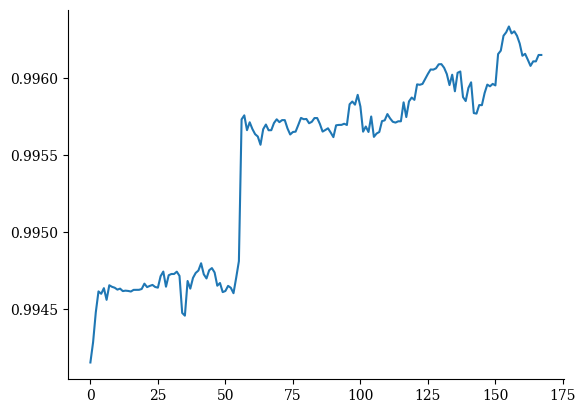

In [14]:
(df["aggregator_price"] / 1e18).plot()